In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pylab import rcParams
from nltk import word_tokenize
from nltk import sent_tokenize
import matplotlib as mpl
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import re
nltk.download('punkt')
nltk.download('stopwords')
!pip install transformers[sentencepiece]
# resource from = https://www.kaggle.com/rareloto/matrix-sentiment-analysis-xlm-roberta

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
     |████████████████████████████████| 1.8MB 5.1MB/s 
     |████████████████████████████████| 890kB 21.2MB/s 
     |████████████████████████████████| 3.2MB 31.0MB/s 
     |████████████████████████████████| 1.1MB 51.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=9095603299924c8297140396c4b0f1f9223dffc553a106607694c617c4bda96d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

- Duplicate reviews and rating
- Text Cleaning : Stemming or lemmatization, drop stopword
- Emoji cleaning
- Handle duplicate char in bahasa
- Noisy Char

# Knowing Our Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146811 entries, 0 to 146810
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  146811 non-null  int64 
 1   review     146811 non-null  object
 2   rating     146811 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [4]:
df.head()

,review_id,review,rating
0,0,Ga disappointed neat products .. Meletot Hilsn...,1
1,1,"Rdtanya replace broken glass, broken chargernya",1
2,2,Nyesel bngt dsni shopping antecedent photo mes...,1
3,3,Sent a light blue suit goods ga want a refund,1
4,4,Pendants came with dents and scratches on its ...,1


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60427 entries, 0 to 60426
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  60427 non-null  int64 
 1   review     60427 non-null  object
dtypes: int64(1), object(1)
memory usage: 944.3+ KB


In [6]:
df_test.head()

,review_id,review
0,1,"Great danger, cool, motif and cantik2 jg model..."
1,2,One of the shades don't fit well
2,3,Very comfortable
3,4,Fast delivery. Product expiry is on Dec 2022. ...
4,5,it's sooooo cute! i like playing with the glit...


# EDA

In [7]:
df['len_words'] = df['review'].apply(lambda x: len(word_tokenize(x)))
df['len_sent'] = df['review'].apply(lambda x: len(sent_tokenize(x)))

Text(0.5, 1.0, 'Length of Words')

<Figure size 2160x360 with 0 Axes>

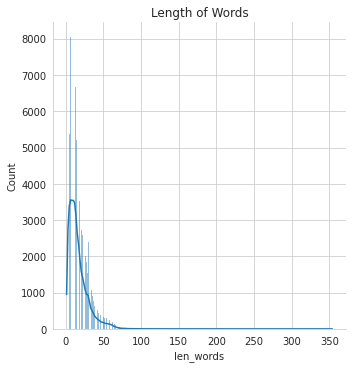

In [8]:
# mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(30,5))
sns.set_style('whitegrid')
sns.displot(df['len_words'],kde=True)
plt.title('Length of Words')

Text(0.5, 1.0, 'Length of Sentences')

<Figure size 2160x360 with 0 Axes>

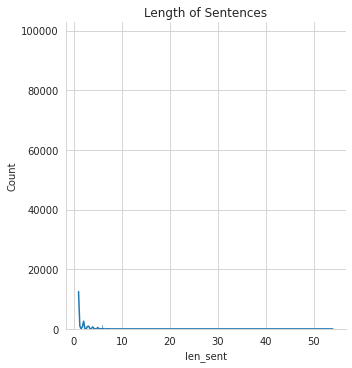

In [9]:
plt.figure(figsize=(30,5))
sns.set_style('whitegrid')
sns.displot(df['len_sent'],kde=True)
plt.title('Length of Sentences')

We won't use encoder decoder because it has long sentences.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rating Ratio')

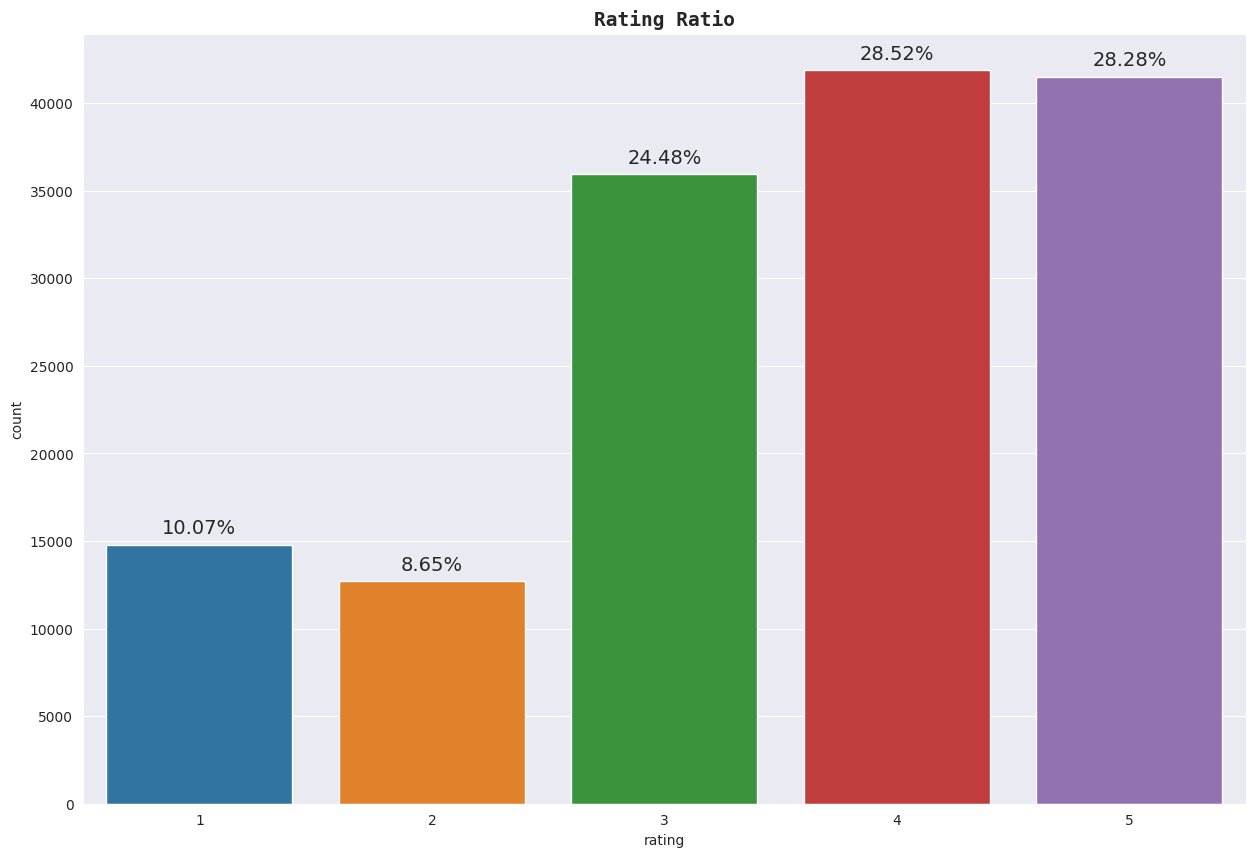

In [10]:
mpl.rcParams.update(mpl.rcParamsDefault)
sns.set_style('darkgrid')
rcParams['figure.figsize']= [15,10]
grid = gridspec.GridSpec(1,1)

ax = sns.countplot(df['rating'])
for val in ax.patches:
  pct = '{:.2f}%'.format(100 * val.get_height() / df.shape[0])
  xpos = val.get_x() + val.get_width() / 2.
  ypos = val.get_height()
  ax.annotate(pct, (xpos, ypos), ha='center', va='center', fontsize=14, xytext=(0, 12), textcoords='offset points')
plt.title('Rating Ratio', fontweight='bold',fontname='Monospace',fontsize=14)

# Duplicated Reviews

In [11]:
len(df[df['review'].duplicated()])

31483

We have 31483 duplicated review, next check based with the rate too

In [12]:
# combine review with the rate
duplicated = df[df.duplicated(subset='review')]
duplicated
duplicated['combine_review_rating'] = duplicated.apply(lambda x:str(x['review'])+str(x['rating']),axis=1)
print(f'{len(duplicated[duplicated["combine_review_rating"].duplicated()]) / len(duplicated) * 100} % is duplicated')

90.59810056220817 % is duplicated


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


90 percentage from duplicated review has duplicate review and rate, better we drop all duplicate

In [13]:
df = df.reset_index().drop(['index','review_id'],axis=1)

In [14]:
!pip install emoji

     |████████████████████████████████| 133kB 4.9MB/s 


# Emoji Preprocessing

In [15]:
import emoji

#Get dataframe index that has emoji in review column
have_emoji_train_idx = []
for i,review in enumerate(df['review']):
  if any(char in emoji.UNICODE_EMOJI['es'] for char in review):
        have_emoji_train_idx.append(i)

In [16]:
print(f'{len(have_emoji_train_idx)} reviews has emojis in train dataset. It means {len(have_emoji_train_idx) / len(df) * 100} % from train dataset') 

18498 reviews has emojis in train dataset. It means 12.599873306496107 % from train dataset


In [17]:
df.iloc[have_emoji_train_idx]

,review,rating,len_words,len_sent
34,It was frustrating seeing order but not receiv...,1,20,1
42,Looks used. Seller claims cannot get 💯 perfect...,1,29,3
69,"Very disappointed, the message that comes even...",1,14,1
75,🤕 disappointed sis,1,3,1
77,Random brand already finished tract a brand bi...,1,24,1
...,...,...,...,...
146782,Mantul ... 😍😍👍👍👍 Cpt bgt sent nya.harganya's a...,5,19,1
146787,"Her material is different is different, but go...",5,40,4
146800,Hehe thanks Baguuuuuuuuuuuus kaaaa😍😍😍😍😍😍😍😍👍👍👍👍...,5,4,1
146801,Explore huge crowd here Children seem to like ...,5,13,1


- Demojize emoji
- Delete repeated emoji

In [18]:
# ps = PorterStemmer()
def emoji_preprocess(text):
  #change emoji to text(Demojize)
  text = emoji.demojize(text).replace(':',' ')
  
  #Delete repeated emoji 
  tokenize = text.split()
  repeated_list = []
  for word in tokenize:
    if word not in repeated_list:
      repeated_list.append(word)
  # drop stopword, lowering, stemming and drop punctuation, exclamation and etc
  # repeated_list  = [ps.stem(re.sub('[^a-z0-9]', ' ',word).lower())for word in repeated_list if word not in stopwords.words('english')]
  
  text = ' '.join(word for word in repeated_list)
  text = text.replace("_"," ").replace("-", " ")
  return text

In [19]:
train_ori = df.copy()
# apply to row index that has emoji in reviw column
df.update(pd.DataFrame(df.loc[have_emoji_train_idx]['review'].apply(emoji_preprocess)),overwrite=True)

In [20]:
train_ori.loc[have_emoji_train_idx]['review']

34        It was frustrating seeing order but not receiv...
42        Looks used. Seller claims cannot get 💯 perfect...
69        Very disappointed, the message that comes even...
75                                       🤕 disappointed sis
77        Random brand already finished tract a brand bi...
                                ...                        
146782    Mantul ... 😍😍👍👍👍 Cpt bgt sent nya.harganya's a...
146787    Her material is different is different, but go...
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa😍😍😍😍😍😍😍😍👍👍👍👍...
146801    Explore huge crowd here Children seem to like ...
146808     Awesome awesome quality merchandise value CP ...
Name: review, Length: 18498, dtype: object

In [21]:
df.loc[have_emoji_train_idx]['review']

34        It was frustrating seeing order but not receiv...
42        Looks used. Seller claims cannot get hundred p...
69        Very disappointed, the message that comes even...
75                  face with head bandage disappointed sis
77        Random brand already finished tract a binigay....
                                ...                        
146782    Mantul ... smiling face with heart eyes thumbs...
146787    Her material is different different, but good ...
146800    Hehe thanks Baguuuuuuuuuuuus kaaaa smiling fac...
146801    Explore huge crowd here Children seem to like ...
146808    Awesome awesome quality merchandise value CP V...
Name: review, Length: 18498, dtype: object

there are some emojis which if demojized will produce some special char instead of words. 

In [22]:
special_emoji_train=[]

for i,review in enumerate(df['review']):
  if re.match(r':\(',review):
    special_emoji_train.append(i)
  elif re.match(r': \(\(',review):
    special_emoji_train.append(i)
  elif re.match(r':, \(', review):
    special_emoji_train.append(i)
  elif re.match(r':\)', review):
    special_emoji_train.append(i)
  elif re.match(r';\)', review):
    special_emoji_train.append(i)
  elif re.match(r':\)\)\)', review):
    special_emoji_train.append(i)
  elif re.match(r':\)\)\)\)\)\)', review):
    special_emoji_train.append(i)
  elif re.match(r'=\)\)\)\)', review):
    special_emoji_train.append(i)

In [23]:
special_emoji_train

[1924, 6897, 14873, 23283]

In [24]:
df.iloc[special_emoji_train]['review']

1924                                :( Gaada deh tp gapapa
6897     :) lack ib delivery but no rep shop :) Soan gu...
14873    :( we put yellow moon, which all goods shop ca...
23283    :)) wrong color buy noble black to red blood p...
Name: review, dtype: object

In [25]:
# make special emoji function
def special_emoji(text):
  #delete newline
  text = re.sub(r'\n', '', text)

  #change several emoticon to text
  text = re.sub(r':\(', 'dislike', text)
  text = re.sub(r': \(\(', 'dislike', text)
  text = re.sub(r':, \(', 'dislike', text)
  text = re.sub(r':\)', 'smile', text)
  text = re.sub(r';\)', 'smile', text)
  text = re.sub(r':\)\)\)', 'smile', text)
  text = re.sub(r':\)\)\)\)\)\)', 'smile', text)
  text = re.sub(r'=\)\)\)\)', 'smile', text)

  #remove any space and give only 1 space to each word in text
  tokenizer = text.split()
  return ' '.join(i for i in tokenizer)

In [26]:
# df.iloc[special_emoji_train]['review'] = df.iloc[special_emoji_train]['review'].apply(special_emoji)
df.update(pd.DataFrame(df.loc[special_emoji_train]['review'].apply(special_emoji)),overwrite=True)

In [27]:
df.iloc[special_emoji_train]['review']

1924                           dislike Gaada deh tp gapapa
6897     smile lack ib delivery but no rep shop smile S...
14873    dislike we put yellow moon, which all goods sh...
23283    smile) wrong color buy noble black to red bloo...
Name: review, dtype: object

# Text Preprocessing

## Repeated Char
- resource = https://www.kaggle.com/indralin/text-processing-augmentation-tpu-baseline-0-4544

In [28]:
df.iloc[146800]['review']

'Hehe thanks Baguuuuuuuuuuuus kaaaa smiling face with heart eyes thumbs up'

it seems many "bahasa" word has repeated character

In [29]:
print(re.sub(r'(\w)\1+',r'\1',df.iloc[146800]['review']))

Hehe thanks Bagus ka smiling face with heart eyes thumbs up


But the problem is many english words have repeated char
the solution is preprocess more than 2 repeated char

In [30]:
print(re.sub(r'(\w)\1{2,}',r'\1',df.iloc[146800]['review']))

Hehe thanks Bagus ka smiling face with heart eyes thumbs up


In [31]:
# Repeated char function
def repeated_char(text):
  text = re.sub(r'(\w)\1{2,}',r'\1',text)
  return text

In [32]:
repeated_char_train = []
for i, review in enumerate(df['review']):
  if re.match(r'\w*(\w)\1+',review):
    repeated_char_train.append(i)

In [33]:
len(repeated_char_train)

26580

In [34]:
df.update(pd.DataFrame(df.loc[repeated_char_train]['review'].apply(repeated_char)),overwrite=True)

In [35]:
train_ori.iloc[repeated_char_train]['review']

8                                  Well, according to Price
14               Small headset sound long side and Delivery
23                              Inaccurate size too small. 
24        Disappointed, received in the form of crushed ...
27                                                   Shoddy
                                ...                        
146769    Tell Â Â Â Â Â Â Â it. That's beautiful, fast ...
146772    Sellernya communicative bgt.ini fabric size is...
146797    supercuteee Oorder seller again thankyou. eh e...
146798    Bagussssssssssssssssssss, Bagussssssssssssssss...
146806    Excellent product quality delivery speed is ve...
Name: review, Length: 26580, dtype: object

In [36]:
df.iloc[repeated_char_train]['review']

8                                  Well, according to Price
14               Small headset sound long side and Delivery
23                              Inaccurate size too small. 
24        Disappointed, received in the form of crushed ...
27                                                   Shoddy
                                ...                        
146769    Tell Â Â Â Â Â Â Â it. That's beautiful, fast ...
146772    Sellernya communicative bgt.ini fabric size is...
146797    supercute Oorder seller again thankyou. eh eh ...
146798                               Bagus, Bagus real pict
146806    Excellent product quality delivery speed is ve...
Name: review, Length: 26580, dtype: object

Delete the row that has noisy text

## Shortened bahasa words to original

In [37]:
def recover_shortened_words(text):
    
    # put \b (boundary) for avoid the characters in the word to be replaced
    # I only make a few examples here, you can add if you're interested :)
    
    text = re.sub(r'\bapaa\b', 'apa', text)
    
    text = re.sub(r'\bbsk\b', 'besok', text)
    text = re.sub(r'\bbrngnya\b', 'barangnya', text)
    text = re.sub(r'\bbrp\b', 'berapa', text)
    text = re.sub(r'\bbgt\b', 'banget', text)
    text = re.sub(r'\bbngt\b', 'banget', text)
    text = re.sub(r'\bgini\b', 'begini', text)
    text = re.sub(r'\bbrg\b', 'barang', text)
    
    text = re.sub(r'\bdtg\b', 'datang', text)
    text = re.sub(r'\bd\b', 'di', text)
    text = re.sub(r'\bsdh\b', 'sudah', text)
    text = re.sub(r'\bdri\b', 'dari', text)
    text = re.sub(r'\bdsni\b', 'disini', text)
    
    text = re.sub(r'\bgk\b', 'gak', text)
    
    text = re.sub(r'\bhrs\b', 'harus', text)
    
    text = re.sub(r'\bjd\b', 'jadi', text)
    text = re.sub(r'\bjg\b', 'juga', text)
    text = re.sub(r'\bjgn\b', 'jangan', text)
    
    text = re.sub(r'\blg\b', 'lagi', text)
    text = re.sub(r'\blgi\b', 'lagi', text)
    text = re.sub(r'\blbh\b', 'lebih', text)
    text = re.sub(r'\blbih\b', 'lebih', text)
    
    text = re.sub(r'\bmksh\b', 'makasih', text)
    text = re.sub(r'\bmna\b', 'mana', text)
    
    text = re.sub(r'\borg\b', 'orang', text)
    
    text = re.sub(r'\bpjg\b', 'panjang', text)
    
    text = re.sub(r'\bka\b', 'kakak', text)
    text = re.sub(r'\bkk\b', 'kakak', text)
    text = re.sub(r'\bklo\b', 'kalau', text)
    text = re.sub(r'\bkmrn\b', 'kemarin', text)
    text = re.sub(r'\bkmrin\b', 'kemarin', text)
    text = re.sub(r'\bknp\b', 'kenapa', text)
    text = re.sub(r'\bkcil\b', 'kecil', text)
    
    text = re.sub(r'\bgmn\b', 'gimana', text)
    text = re.sub(r'\bgmna\b', 'gimana', text)
    
    text = re.sub(r'\btp\b', 'tapi', text)
    text = re.sub(r'\btq\b', 'thanks', text)
    text = re.sub(r'\btks\b', 'thanks', text)
    text = re.sub(r'\btlg\b', 'tolong', text)
    text = re.sub(r'\bgk\b', 'tidak', text)
    text = re.sub(r'\bgak\b', 'tidak', text)
    text = re.sub(r'\bgpp\b', 'tidak apa apa', text)
    text = re.sub(r'\bgapapa\b', 'tidak apa apa', text)
    text = re.sub(r'\bga\b', 'tidak', text)
    text = re.sub(r'\btgl\b', 'tanggal', text)
    text = re.sub(r'\btggl\b', 'tanggal', text)
    text = re.sub(r'\bgamau\b', 'tidak mau', text)
    
    text = re.sub(r'\bsy\b', 'saya', text)
    text = re.sub(r'\bsis\b', 'sister', text)
    text = re.sub(r'\bsdgkan\b', 'sedangkan', text)
    text = re.sub(r'\bmdh2n\b', 'semoga', text)
    text = re.sub(r'\bsmoga\b', 'semoga', text)
    text = re.sub(r'\bsmpai\b', 'sampai', text)
    text = re.sub(r'\bnympe\b', 'sampai', text)
    text = re.sub(r'\bdah\b', 'sudah', text)
    
    text = re.sub(r'\bberkali2\b', 'repeated', text)
    
    text = re.sub(r'\byg\b', 'yang', text)
    
    return text

In [38]:
df.update(pd.DataFrame(df['review'].apply(recover_shortened_words)),overwrite=True)

## Stemming/ Lemmatization, Lowercase, Drop Stopwords

I prefer stemming because it takes less computational time :D

In [39]:
ps = PorterStemmer()
def stem_lowercase_stopwords(text):
  tokenize = word_tokenize(text)
  word  = [ps.stem(re.sub('[^a-zA-Z0-9]', ' ',word).lower())for word in tokenize if word not in stopwords.words('english')]
  word = ' '.join(i for i in word)
  return word

In [40]:
df['review'] = df['review'].apply(stem_lowercase_stopwords)

In [41]:
df['review'].tail()

146806    excel product qualiti deliveri speed good    g...
146807                                            thank gan
146808    awesom awesom qualiti merchandis valu cp veri ...
146809    nice pack box made effect price               ...
146810    excel product qualiti excel product price good...
Name: review, dtype: object

# WordCloud + EDA

In [42]:
from wordcloud import WordCloud, ImageColorGenerator

In [43]:
rating_1 = df[df['rating'] == 1]['review']
rating_2 = df[df['rating'] == 2]['review']
rating_3 = df[df['rating'] == 3]['review']
rating_4 = df[df['rating'] == 4]['review']
rating_5 = df[df['rating'] == 5]['review']

rating_1_text = ' '.join([text for text in rating_1])
rating_2_text = ' '.join([text for text in rating_2])
rating_3_text = ' '.join([text for text in rating_3])
rating_4_text = ' '.join([text for text in rating_4])
rating_5_text = ' '.join([text for text in rating_5])

## Rating 1

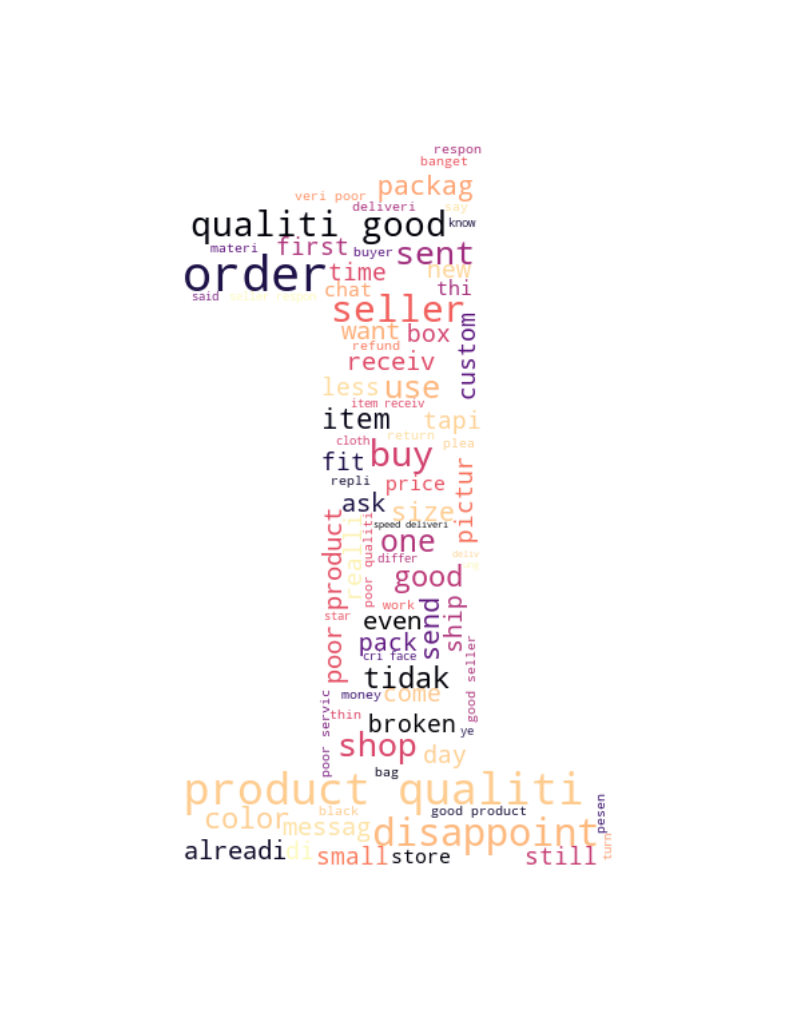

In [44]:
from PIL import Image
# rcParams.update(mpl.rcParamsDefault)
rcParams['figure.figsize'] = [10,35]
mask = np.array(Image.open('number1.png'))

rating_1_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma', max_words=80, mask=mask).generate(rating_1_text)
plt.imshow(rating_1_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Rating 2

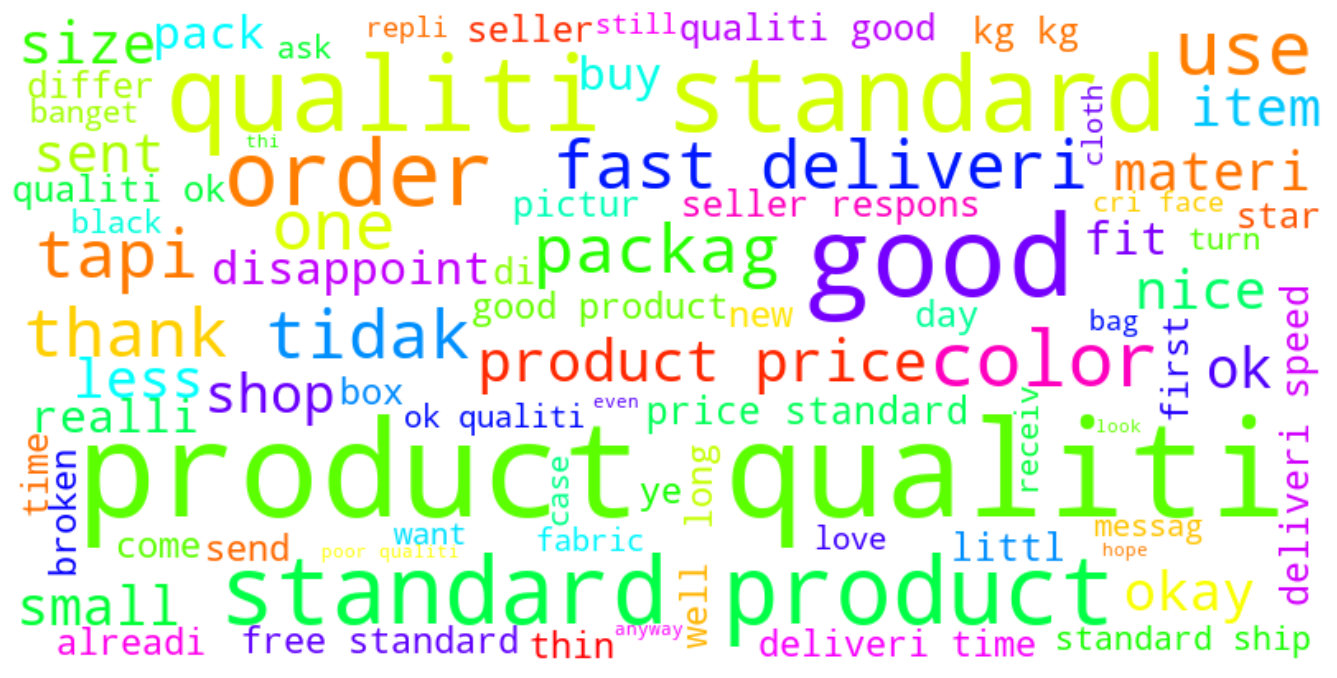

In [45]:
rcParams['figure.figsize'] = [17,35]
# mask = np.array(Image.open('number2.png'))
rating_2_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='gist_rainbow_r', max_words=80).generate(rating_2_text)
plt.imshow(rating_2_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Rating 3

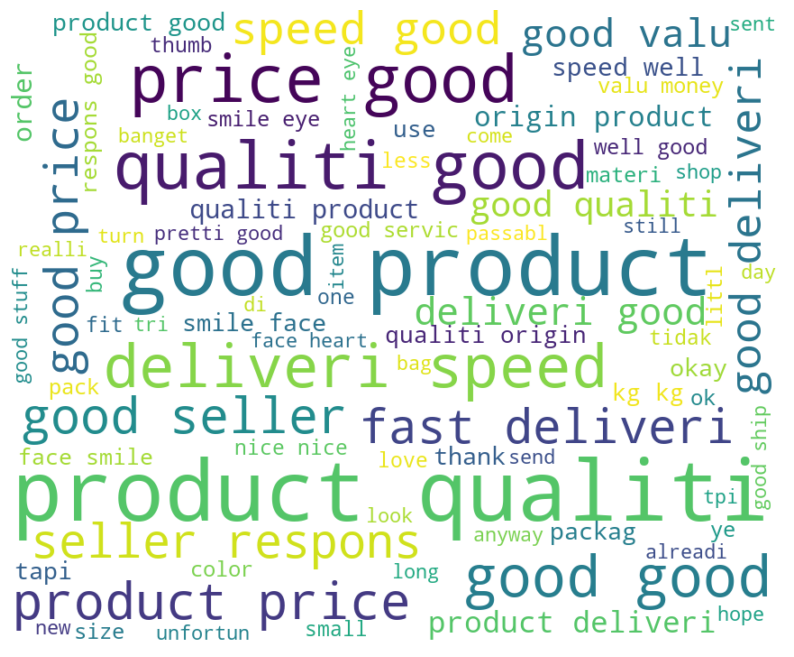

In [46]:
rcParams['figure.figsize'] = [10,20]
mask = np.array(Image.open('number3.png'))
rating_3_wordcloud = WordCloud(width=800, height=400, mask=mask, background_color='white', colormap='viridis', max_words=80).generate(rating_3_text)
plt.imshow(rating_3_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Rating 4

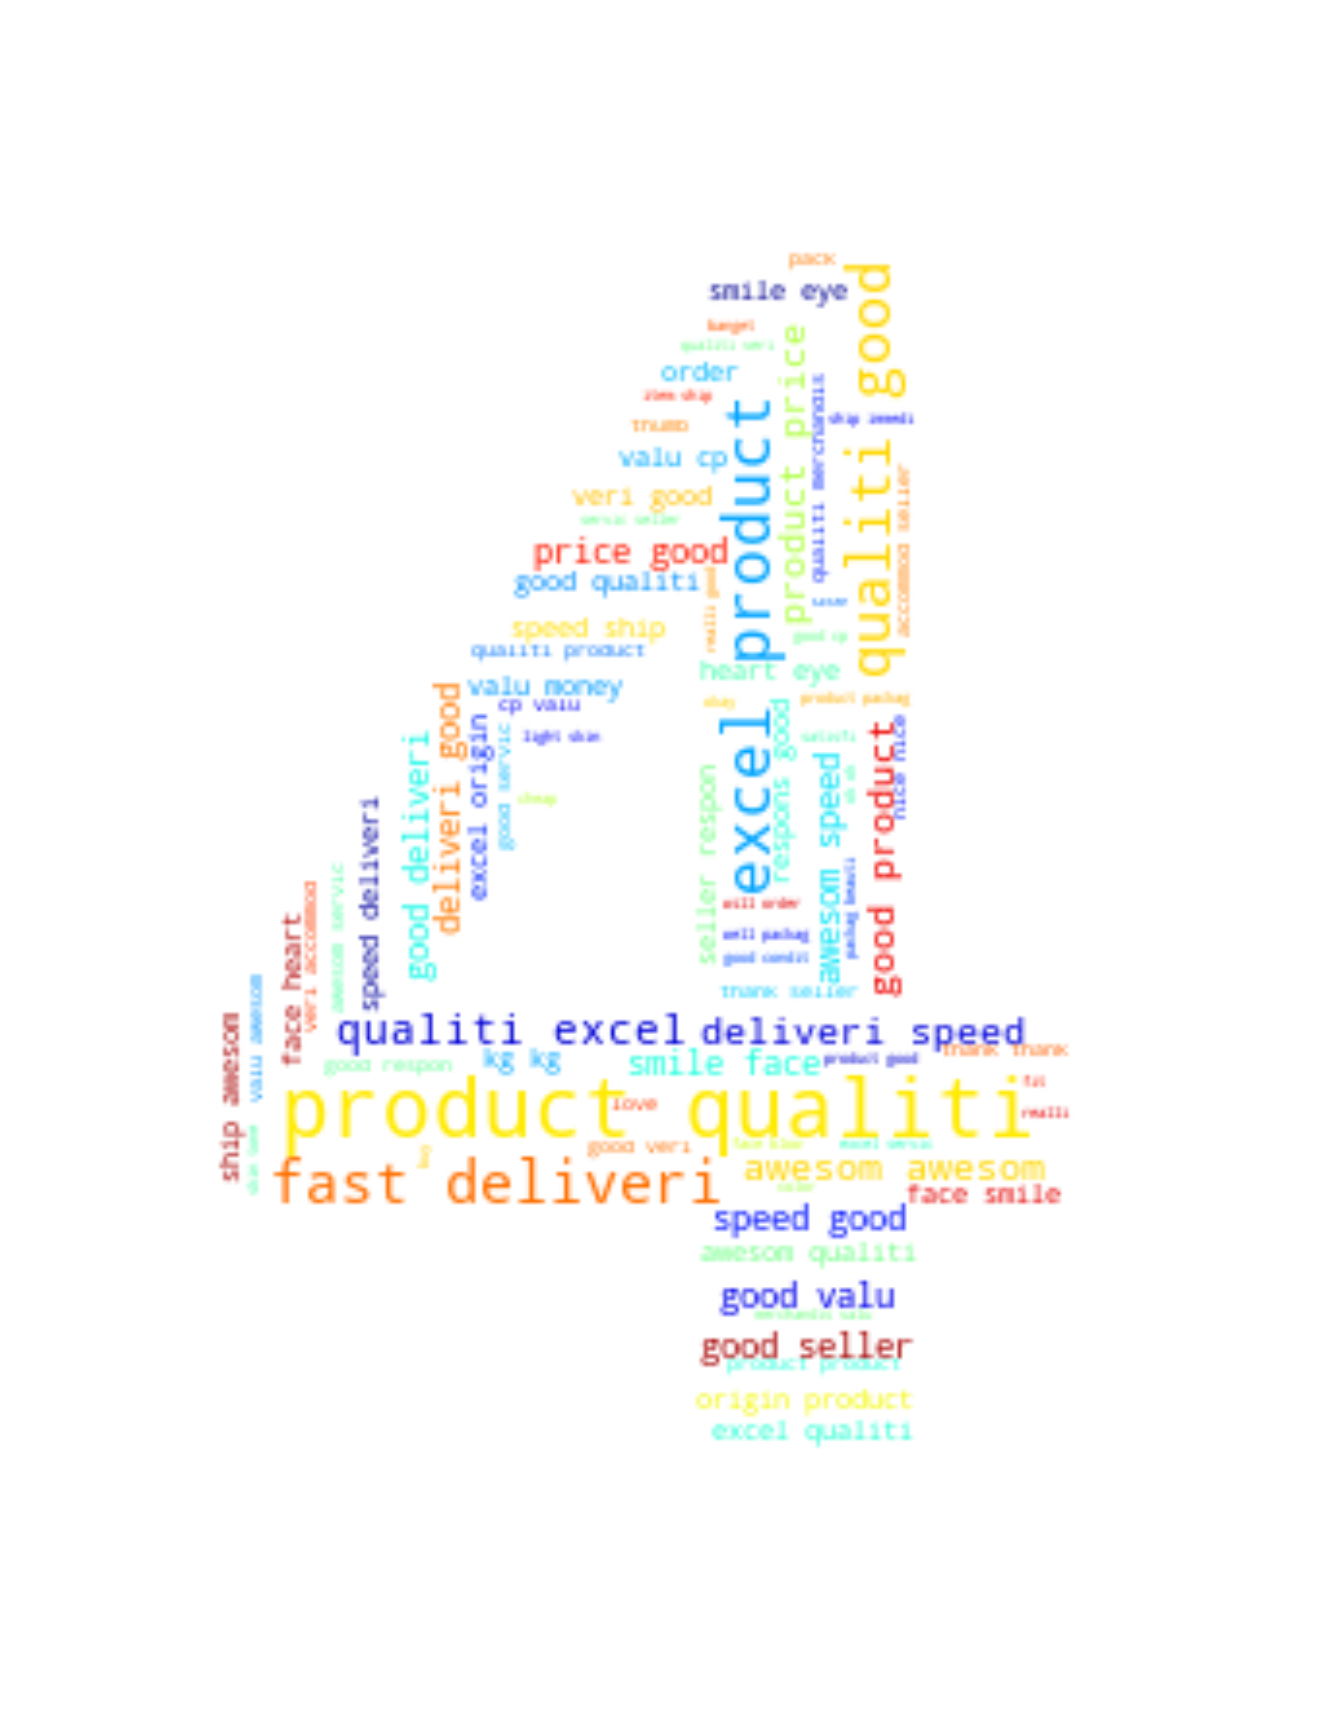

In [47]:
rcParams['figure.figsize'] = [17,35]
mask = np.array(Image.open('number4.jpg'))
rating_4_wordcloud = WordCloud(width=800, height=400, mask=mask, background_color='white', colormap='jet', max_words=80).generate(rating_4_text)
plt.imshow(rating_4_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Rating 5

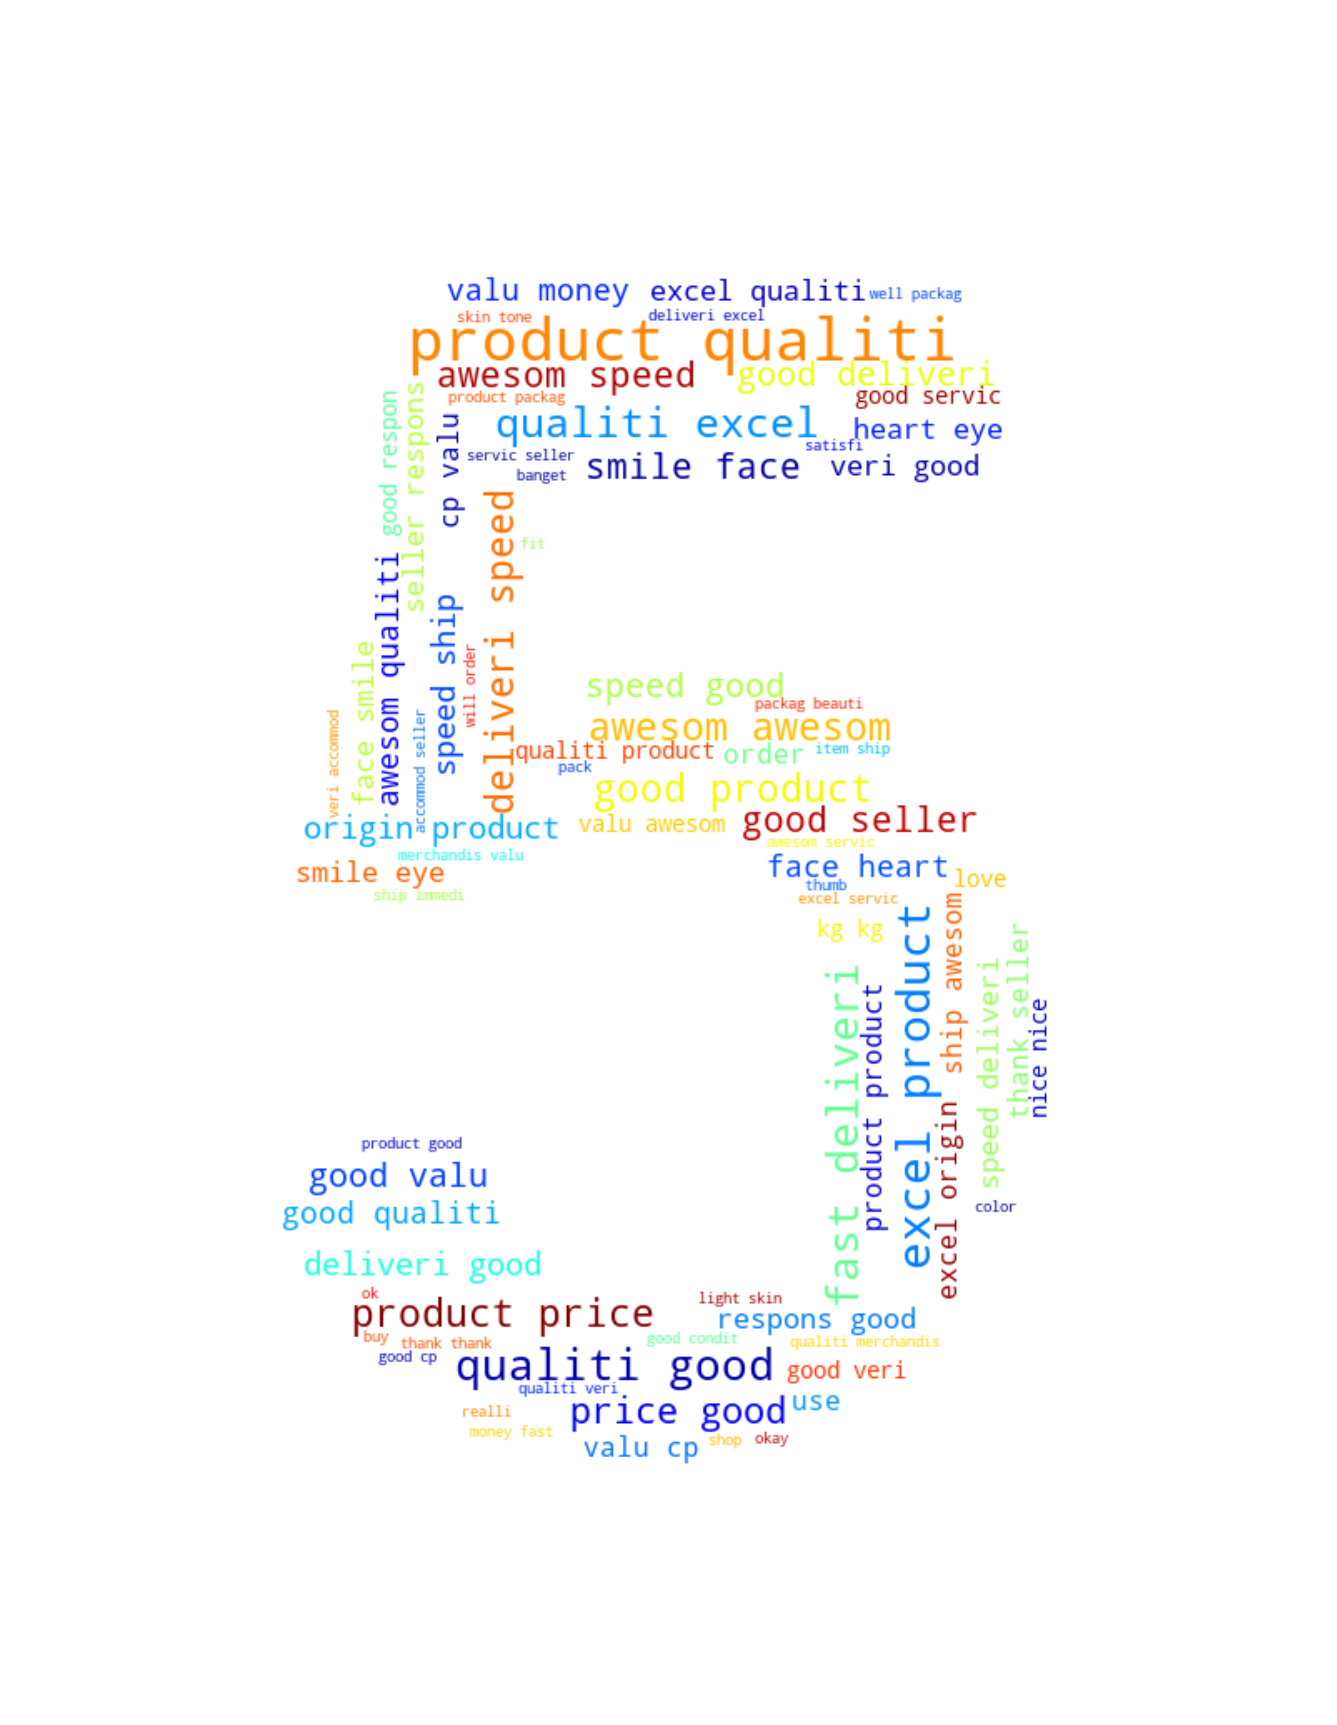

In [48]:
rcParams['figure.figsize'] = [17,35]
mask = np.array(Image.open('number5.jpg'))
rating_5_wordcloud = WordCloud(width=800, height=400, mask=mask, background_color='white', colormap='jet', max_words=80).generate(rating_5_text)
plt.imshow(rating_5_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Text Augmentation
- Synonym Replacement: Randomly replace n words in the sentences with their synonyms
- Random Insertion: Insert random synonyms of words in a sentence, this is done n times
- Random Deletion: Random removal for each word in the sentence with a probability p
- Contextualized Word Embeddings
- Text Generation (GPT-2 or XLNet)

## Contextualized Word Embeddings


In [49]:
# %%time

# review_augmented = []

# # action = "insert" or 'substitute (default)'
# aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action='insert')
# # aug = naw.ContextualWordEmbsAug(model_path='bert-base-multilingual-uncased', action='substitute', aug_p=0.5) # higher aug_p = substitute more words

# for review in df['review']:
#     augmented_text = aug.augment(review)
#     review_augmented.append(augmented_text)

In [50]:
# train_aug = pd.DataFrame({'review': review_augmented,
#                           'rating': train_df['rating']})

# # filter rows that have words less than 10
# train_aug[train_aug['review'].str.len() >= 10].to_csv('review_aug_insert.csv', index=False)

# Modelling

In [51]:
!pip install transformers

In [52]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

print('Using Tensorflow version:', tf.__version__)

Using Tensorflow version: 2.4.1


In [53]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
             texts, 
             return_attention_masks=False, 
             return_token_type_ids=False,
             pad_to_max_length=True,
             max_length=maxlen)
    
    return np.array(enc_di['input_ids'])

In [54]:
def build_model(transformer, max_len=512):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(5, activation='softmax')(cls_token) # 5 ratings to predict
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [55]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.41.104.114:8470


INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


INFO:tensorflow:Initializing the TPU system: grpc://10.41.104.114:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.41.104.114:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [56]:
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 4
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MODEL = 'jplu/tf-xlm-roberta-large' # bert-base-multilingual-uncased

In [57]:
# since keras takes 0 as the reference, our category should start from 0 not 1
rating_mapper_encode = {1: 0,
                        2: 1,
                        3: 2,
                        4: 3,
                        5: 4}

# convert back to original rating after prediction later
rating_mapper_decode = {0: 1,
                        1: 2,
                        2: 3,
                        3: 4,
                        4: 5}

df['rating'] = df['rating'].map(rating_mapper_encode)

In [58]:
from tensorflow.keras.utils import to_categorical

# convert to one-hot-encoding-labels
train_labels = to_categorical(df['rating'], num_classes=5)

In [59]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df['review'],
                                                  train_labels,
                                                  stratify=train_labels,
                                                  test_size=0.1,
                                                  random_state=1111)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((132129,), (14682,), (132129, 5), (14682, 5))

In [60]:
# load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [62]:
MAX_LEN = df['len_words'].max()

X_train = regular_encode(X_train.values, tokenizer, maxlen=MAX_LEN)
X_val = regular_encode(X_val.values, tokenizer, maxlen=MAX_LEN)
# X_test = regular_encode(df_test['review'].values, tokenizer, maxlen=MAX_LEN)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2155: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


TypeError: ignored

In [ ]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train, y_train))
    .repeat()
    .shuffle(1024)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

# test_dataset = (
#     tf.data.Dataset
#     .from_tensor_slices(X_test)
#     .batch(BATCH_SIZE)
# )

In [ ]:
%%time

with strategy.scope():
    transformer_layer = TFAutoModel.from_pretrained(MODEL)
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

In [ ]:
n_steps = X_train.shape[0] // BATCH_SIZE

train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=EPOCHS
)

## Plot Loss

In [ ]:
plt.style.use('fivethirtyeight')

# Get training and test loss histories
training_loss = train_history.history['loss']
test_loss = train_history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## Predict test dataset

In [ ]:
# pred = model.predict(test_dataset, verbose=1)
